In [97]:
# data wrangling imports
import pandas as pd
import numpy as np

# Plotting imports
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rasterio.plot import show
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# GIS imports
from shapely.geometry import Point
from osgeo import gdal
from rasterio.merge import merge
import rasterio
import contextily as cx
import folium

# Other
from datetime import datetime, timedelta
from collections import defaultdict


The dataset from https://www.kaggle.com/discussions/accomplishments/493652
can be used to study the extent of wildires at a large scale in Africa. In this notebook, we will retrieve data from __ wildfires to understand its impact.

In [98]:
# Load datasets
wfWeekly = pd.read_csv("1- cumulative-area-burnt-by-wildfires-by-week.csv")
wfAnnualy = pd.read_csv("2- annual-area-burnt-by-wildfires.csv")
area = pd.read_csv("3- share-of-the-total-land-area-burnt-by-wildfires-each-year.csv")
landArea = pd.read_csv("4- annual-area-burnt-per-wildfire.csv")
landCover = pd.read_csv("5- annual-burned-area-by-landcover.csv")

# Clean up datasets
wfWeekly.columns = wfWeekly.columns.str.strip()

# Convert Year to datetime
wfWeekly['Year'] = pd.to_datetime(wfWeekly['Year'])

# Melt the dataframe to long format
wfWeekly_long = pd.melt(wfWeekly, 
                        id_vars=['Entity', 'Code', 'Year'], 
                        var_name='YearBurnt', 
                        value_name='CumulativeAreaBurnt')

# Extract year from 'YearBurnt' column
wfWeekly_long['YearBurnt'] = wfWeekly_long['YearBurnt'].str.extract('(\d{4})').astype(int)

# Filter data for Afghanistan
afghanistan_data = wfWeekly_long[wfWeekly_long['Entity'] == 'Afghanistan']


wfWeekly.head()
wfAnnualy.head()
area.head()
landArea.head()
landCover.head()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/m_/rqbd66b92rj16fnsfvbljqn40000gn/T/ipykernel_68406/353903482.py:21: SyntaxWarning: invalid escape sequence '\d'
  wfWeekly_long['YearBurnt'] = wfWeekly_long['YearBurnt'].str.extract('(\d{4})').astype(int)


,Entity,Code,Year,Yearly burned area across other land categories,Yearly burned area across croplands,Yearly burned area across forests,Yearly burned area across savannas,Yearly burned area across shrublands and grasslands
0,Afghanistan,AFG,2002,0.0000,14167.473,0.0,0.000,18052.793
1,Afghanistan,AFG,2003,1309.4180,21680.530,0.0,0.000,112030.360
2,Afghanistan,AFG,2004,407.8520,4357.571,0.0,0.000,24556.953
3,Afghanistan,AFG,2005,85.8640,1395.281,0.0,64.398,10883.193
4,Afghanistan,AFG,2006,1116.2269,9809.900,0.0,64.398,7169.603


In [99]:
# Create a map centered on Afghanistan
afghanistan_center = Point(69.2075, 34.5553)
m = folium.Map(location=[afghanistan_center.y, afghanistan_center.x], zoom_start=6, control_scale=True)


In [100]:
# Add circles for each year's data
for year in range(2012, 2025):  # Adjust range as needed
    column_name = f'Cumulative area burnt by wildfires in {year}'
    if column_name in afghanistan_data.columns:
        area = afghanistan_data[column_name].max()
        folium.Circle(
            location=[afghanistan_center.y, afghanistan_center.x],
            radius=area / 10,  # Adjust this factor as needed
            color="red",
            fill=True,
            fill_opacity=0.6,
            opacity=1,
            popup=f"Year: {year}, Area: {area} sq km",
            tooltip=f"{year}: {area} sq km"
        ).add_to(m)

# Display the map
m

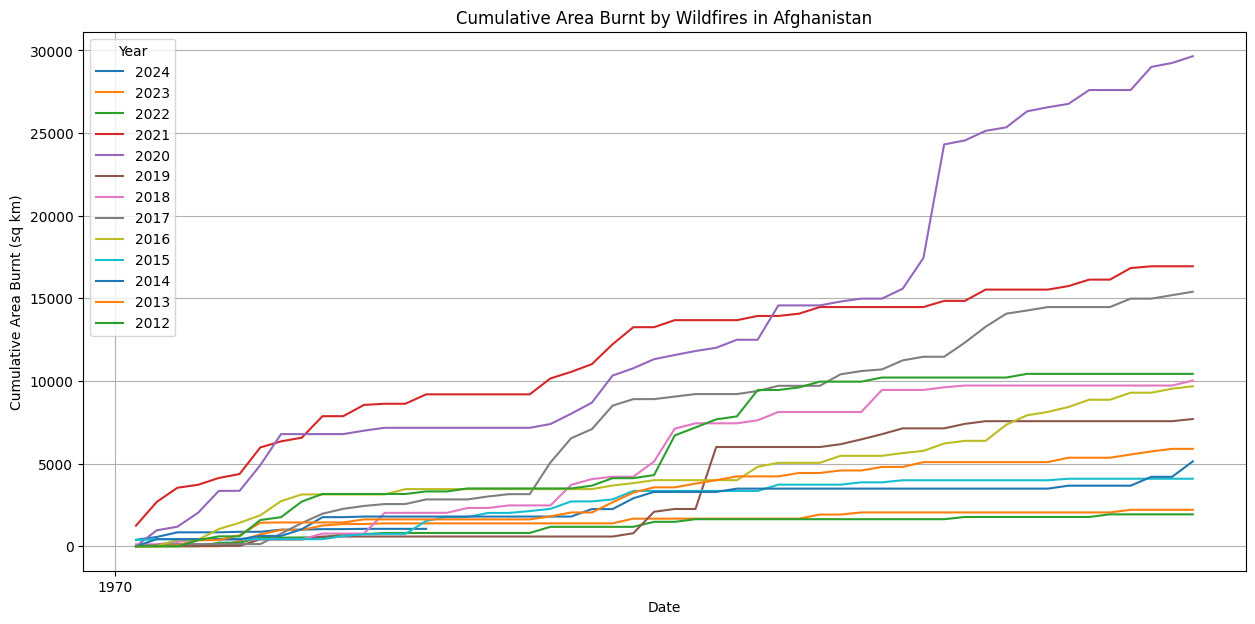

In [101]:
# Plot time series of cumulative area burnt
plt.figure(figsize=(15, 7))
for year in afghanistan_data['YearBurnt'].unique():
    year_data = afghanistan_data[afghanistan_data['YearBurnt'] == year]
    plt.plot(year_data['Year'], year_data['CumulativeAreaBurnt'], label=year)

plt.title('Cumulative Area Burnt by Wildfires in Afghanistan')
plt.xlabel('Date')
plt.ylabel('Cumulative Area Burnt (sq km)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

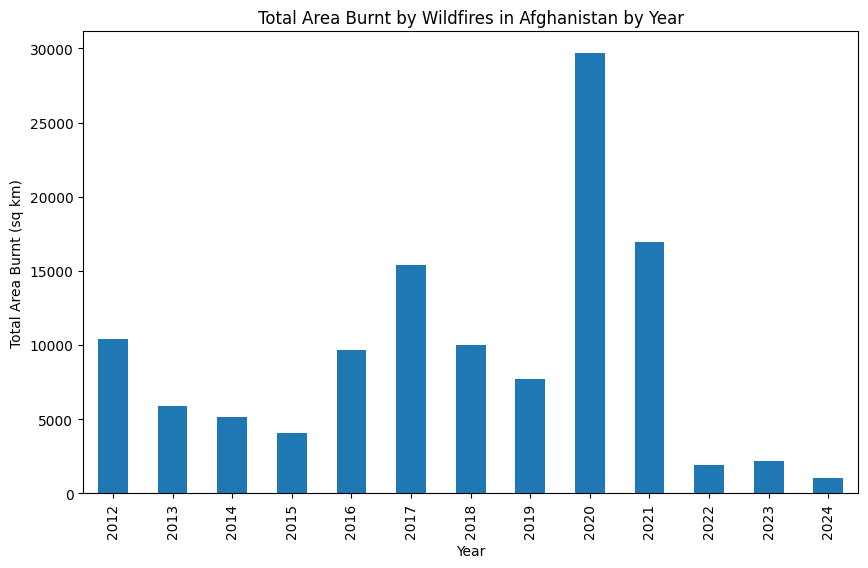

In [102]:
# Calculate total area burnt per year
yearly_totals = afghanistan_data.groupby('YearBurnt')['CumulativeAreaBurnt'].max()

# Plot yearly totals
plt.figure(figsize=(10, 6))
yearly_totals.plot(kind='bar')
plt.title('Total Area Burnt by Wildfires in Afghanistan by Year')
plt.xlabel('Year')
plt.ylabel('Total Area Burnt (sq km)')
plt.show()

# Analyze land cover types affected (if available in your dataset)
if 'Land cover type' in landCover.columns:
    afghanistan_landcover = landCover[landCover['Entity'] == 'Afghanistan']
    
    plt.figure(figsize=(12, 6))
    afghanistan_landcover.plot(x='Land cover type', y='Burned area', kind='bar')
    plt.title('Burned Area by Land Cover Type in Afghanistan')
    plt.xlabel('Land Cover Type')
    plt.ylabel('Burned Area')
    plt.xticks(rotation=45)
    plt.show()